In [2]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from scripts.ising_simulation import IsingSimulation
from joblib import Parallel, delayed
from scipy import optimize


In [3]:
bold = np.loadtxt('../data/50003_timeseries.txt')
bold_bin = np.zeros(bold.shape)
bold_bin[np.where(bold>=0)] = 1
bold_bin[np.where(bold<0)] = -1
n_rois = bold_bin.shape[1]
n_timesteps = bold_bin.shape[0]

In [4]:
beta = 0.1
state = bold_bin
state.shape

(196, 116)

In [48]:
def loss(J, s, b):
#     print(s.shape)
    J = np.reshape(J, (n_rois, n_rois))
#     print(J.shape)
    term1 = 0
    term2 = 0
    for t in range(n_timesteps):
        C = b * J @ s[t].T
        term1 += C @ s[t].T
        term2 -= np.sum(np.log(np.exp(C) + np.exp(-C)))
    return (term1+term2)/n_timesteps

def gradient(J, s, b):
    J = np.reshape(J, (n_rois, n_rois))
    grad = np.zeros((n_rois, n_rois))
    for t in range(n_timesteps):
        C = b * J @ s[t].T
        grad += np.outer(s[t], s[t].T) - np.outer(np.tanh(C).T, s[t])
    grad = grad * b/n_timesteps
    return grad

In [49]:
def gradient_ascent(max_iterations,w_init,
                     obj_func,grad_func,extra_param = (),
                     learning_rate=0.05,momentum=0.8, threshold=0.001):
    
    w = w_init
    w_history = [w]
    f_history = [obj_func(w,*extra_param)]
    delta_w = np.zeros(w.shape)
    i = 0
    diff = 1.0e10
    
    while i<max_iterations and diff > threshold:
        grad = grad_func(w,*extra_param)
        # print("from func", grad.shape)
        grad = np.reshape(grad, (n_rois, n_rois))
        # print(grad.shape)
        delta_w = learning_rate*grad
        w = w+delta_w
        w_history.append(w)
        f_history.append(obj_func(w,*extra_param))
        if i%10 == 0: 
            print(f"iteration: {i} loss: {f_history[-1]} grad: {np.sum(grad)}")
        i+=1
        diff = np.absolute(f_history[-1]-f_history[-2])
    
    return w_history,f_history

In [56]:
sim_timesteps = 20
eq_steps = 1000     #  number of MC sweeps for equilibration
σ = 10000
α = 0.1

In [51]:
J = np.random.uniform(0, 1, size=(n_rois, n_rois))
J = (J + J.T)/2 # making it symmetric
np.fill_diagonal(J, 0)

In [52]:
fc = 1/n_timesteps * bold_bin.T @ bold_bin

In [ ]:
J_hist, f_hist = gradient_ascent(σ, J, loss, gradient, extra_param=(bold_bin, beta), learning_rate=α)
J_max = J_hist[f_hist.index(max(f_hist))]
sim = IsingSimulation(n_rois, beta, coupling_mat = True, J=J_max)
for i in range(eq_steps):
    sim.step()

In [ ]:
res = optimize.fmin_cg(loss, x0=J.flatten(), fprime=gradient, args=(bold_bin, ), disp=True, callback=lambda x: print(f'loss: {loss(x, bold_bin)}'))

In [18]:
init_state = np.ones(n_rois)

In [19]:
sim = IsingSimulation(n_rois, beta, coupling_mat = True, J=J_max, initial_state=True, state=init_state)
print(sim.state)
M = []
E = []
for i in range(eq_steps):
    sim.step()
    M.append(sim.calcMag())
    E.append(sim.calcEnergy())
print(sim.state)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [76]:
n_timesteps = 20

In [77]:
time_series = np.zeros((n_timesteps, n_rois))
state = sim.state[:]
for i in range(n_timesteps):
    state = sim.step(False, state)
    time_series[i] = state
print(np.sum(time_series))
sim_fc = 1/n_timesteps * time_series.T @ time_series 

-1760.0


In [57]:
def corr_analysis(beta, fc):
    print(beta)
    J = np.random.uniform(0, 1, size=(n_rois, n_rois))
    J = (J + J.T)/2 # making it symmetric
    np.fill_diagonal(J, 0)
    J_hist, f_hist = gradient_ascent(σ, J, loss, gradient, extra_param=(bold_bin, beta), learning_rate=α)
    J_max = J_hist[f_hist.index(max(f_hist))]
    sim = IsingSimulation(n_rois, beta, coupling_mat = True, J=J_max)
    for i in range(eq_steps):
        sim.step()
    _, sim_fc = sim.getTimeseries(n_timesteps)
    c = np.corrcoef(np.triu(fc).flatten(), np.triu(sim_fc).flatten())[0, 1]
    return c

In [58]:
corr_analysis(1, fc)

1
iteration: 0 loss: -1164.2871777895325 grad: -2203.7876849029717
iteration: 10 loss: -1154.9696422055001 grad: -2203.744943207862
iteration: 20 loss: -1145.6702551765302 grad: -2203.683843239097
iteration: 30 loss: -1136.3892568584101 grad: -2203.6041471224
iteration: 40 loss: -1127.1268731453847 grad: -2203.5056843388593
iteration: 50 loss: -1117.8833035932125 grad: -2203.3883154700266
iteration: 60 loss: -1108.6587168897722 grad: -2203.251878318165
iteration: 70 loss: -1099.453254652123 grad: -2203.096139375947
iteration: 80 loss: -1090.2670417060103 grad: -2202.9207651434654
iteration: 90 loss: -1081.1002001269653 grad: -2202.7253197214595
iteration: 100 loss: -1071.952863568424 grad: -2202.509290247609
iteration: 110 loss: -1062.8251878954936 grad: -2202.272130331612
iteration: 120 loss: -1053.7173552696167 grad: -2202.013298393136
iteration: 130 loss: -1044.6295716205652 grad: -2201.732266057872
iteration: 140 loss: -1035.5620605222543 grad: -2201.428485211554
iteration: 150 los

KeyboardInterrupt: 

In [26]:
corr = []
for i in np.linspace(0, 1, 20):
    c = corr_analysis(i, fc)
    corr.append(c)

iteration: 0 loss: 141.27549065899245 grad: 187.34407103352828
iteration: 10 loss: 231.97767175052803 grad: 197.9661688473745
iteration: 20 loss: 336.429713280668 grad: 195.4346220286714
iteration: 30 loss: 449.1200361318037 grad: 188.94741888370348
iteration: 40 loss: 567.590242249011 grad: 181.41872080772123
iteration: 50 loss: 690.6059553467371 grad: 173.45831422899073


KeyboardInterrupt: 

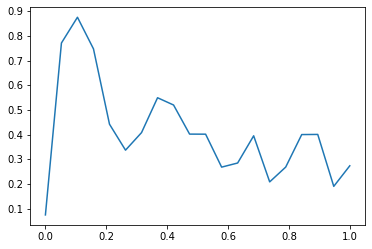

In [ ]:
plt.plot(np.linspace(0, 1, 20), corr)

In [27]:
fc = 1/n_timesteps * bold_bin.T @ bold_bin
results = Parallel(n_jobs=8)(delayed(corr_analysis)(i, fc) for i in np.linspace(0, 4, 20))

iteration: 0 loss: 140.6381637810415 grad: 187.75364391612715
iteration: 0 loss: 141.40100387700136 grad: 187.61166022558484
iteration: 0 loss: 139.70721897456104 grad: 186.7486256554929
iteration: 0 loss: 139.9839880798173 grad: 186.80171770995156iteration: 0 loss: 140.82678844377128 grad: 187.09036078539933
iteration: 0 loss: 140.36581272523478 grad: 187.23697325481737
iteration: 0 loss: 140.84347369310015 grad: 187.27855739293508

iteration: 0 loss: 141.4215465440448 grad: 187.41536192253528
iteration: 10 loss: 230.49381508739557 grad: 198.98158638077194
iteration: 10 loss: 230.95880006286566 grad: 198.24586809482528
iteration: 10 loss: 231.98424362734949 grad: 198.15409309226038
iteration: 10 loss: 231.21110936698062 grad: 198.2027169881814
iteration: 10 loss: 229.6410560050476 grad: 198.08588739582578
iteration: 10 loss: 231.60690613955106 grad: 198.65067914284532
iteration: 10 loss: 230.4200074597521 grad: 198.3630715289915
iteration: 10 loss: 230.2746446488316 grad: 197.93234132

/tmp/ipykernel_3654/168530359.py:10: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_3654/2232348269.py:24: RuntimeWarning: invalid value encountered in double_scalars


iteration: 1690 loss: 37170.874827719956 grad: -72.81129206429566iteration: 1660 loss: 36285.023572144346 grad: -67.09872450219254

iteration: 1650 loss: 36272.55402945307 grad: -72.61352396676284
iteration: 1590 loss: 34772.9783174922 grad: -70.63133838508284
iteration: 1600 loss: 34910.93931370389 grad: -67.72703618592769


/tmp/ipykernel_3654/168530359.py:10: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_3654/168530359.py:10: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_3654/2232348269.py:24: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_3654/2232348269.py:24: RuntimeWarning: invalid value encountered in double_scalars


iteration: 1670 loss: inf grad: -71.98881462681493
iteration: 1670 loss: inf grad: -72.74121574531688
iteration: 1650 loss: 36251.694053815765 grad: -73.96222478001556
iteration: 1670 loss: 36524.96763231589 grad: -67.42047950832442
iteration: 1700 loss: inf grad: -72.99870677135536
iteration: 1660 loss: 36515.18061903607 grad: -72.8054925534875
iteration: 1600 loss: 35015.08046566887 grad: -70.83326672097444
iteration: 1680 loss: inf grad: -72.23234560455796
iteration: 1610 loss: 35151.84356187225 grad: -67.93508356386823
iteration: 1680 loss: inf grad: -72.95995448345963


/tmp/ipykernel_3654/168530359.py:10: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_3654/168530359.py:10: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_3654/2232348269.py:24: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_3654/2232348269.py:24: RuntimeWarning: invalid value encountered in double_scalars


iteration: 1680 loss: inf grad: -67.73648925652631
iteration: 1710 loss: inf grad: -73.18551478550323
iteration: 1660 loss: 36494.9434536624 grad: -74.20339038055911
iteration: 1670 loss: inf grad: -72.95440068161031
iteration: 1610 loss: 35257.24087224637 grad: -70.99412786160006


/tmp/ipykernel_3654/168530359.py:10: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_3654/2232348269.py:24: RuntimeWarning: invalid value encountered in double_scalars


iteration: 1690 loss: inf grad: -72.43437386492961
iteration: 1620 loss: 35392.83769746254 grad: -68.14050933723802
iteration: 1690 loss: inf grad: -73.19824827248387
iteration: 1690 loss: inf grad: -68.07315886617957
iteration: 1720 loss: inf grad: -73.36337097760895
iteration: 1670 loss: inf grad: -74.44735995607857
iteration: 1700 loss: inf grad: -72.65473958237946
iteration: 1630 loss: 35633.921606289245 grad: -68.36713797457767
iteration: 1680 loss: inf grad: -73.12159202025126
iteration: 1700 loss: inf grad: -73.38585683905072
iteration: 1620 loss: 35499.460680351745 grad: -71.18868579850931
iteration: 1700 loss: inf grad: -68.37286407488908
iteration: 1680 loss: inf grad: -74.66567592620132
iteration: 1730 loss: inf grad: -73.58413227970377
iteration: 1710 loss: inf grad: -72.8914368979514
iteration: 1690 loss: inf grad: -73.36238007282651
iteration: 1640 loss: 35875.10058416932 grad: -68.63510451121735
iteration: 1710 loss: inf grad: -73.57047984281434
iteration: 1630 loss: 357

/tmp/ipykernel_3654/168530359.py:10: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_3654/2232348269.py:24: RuntimeWarning: invalid value encountered in double_scalars


iteration: 1750 loss: inf grad: -69.37433063844306


/tmp/ipykernel_3654/168530359.py:10: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_3654/2232348269.py:24: RuntimeWarning: invalid value encountered in double_scalars


iteration: 1760 loss: inf grad: -73.89419218088565
iteration: 1740 loss: inf grad: -74.31666928293572
iteration: 1780 loss: inf grad: -74.58921269897535
iteration: 1760 loss: inf grad: -74.83832189136751
iteration: 1690 loss: inf grad: -70.05550706092744
iteration: 1730 loss: inf grad: -75.75870407460769
iteration: 1680 loss: inf grad: -72.72097724548729
iteration: 1760 loss: inf grad: -69.49823913202096
iteration: 1770 loss: inf grad: -74.08987119726669
iteration: 1750 loss: inf grad: -74.63497325064552
iteration: 1790 loss: inf grad: -74.7760255477976iteration: 1770 loss: inf grad: -75.02055772167341

iteration: 1700 loss: inf grad: -70.36126875003634
iteration: 1740 loss: inf grad: -75.94720255565518
iteration: 1770 loss: inf grad: -69.65157593704404
iteration: 1690 loss: inf grad: -72.97144724255436
iteration: 1780 loss: inf grad: -74.29366479149155
iteration: 1760 loss: inf grad: -74.9297993313602
iteration: 1780 loss: inf grad: -75.1750938128207
iteration: 1800 loss: inf grad: -7

KeyboardInterrupt: 

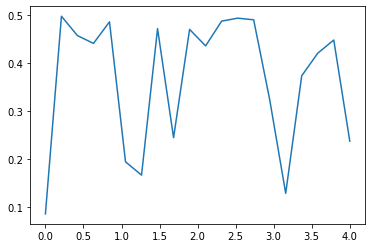

iteration: 0 loss: -1143.8887577835264
iteration: 10 loss: -1089.3616006768607
iteration: 20 loss: -1040.1259801254557
iteration: 30 loss: -995.8901156940434
iteration: 40 loss: -955.2442266969058
iteration: 50 loss: -918.6159374310795
iteration: 60 loss: -886.6750608890139
iteration: 70 loss: -859.74050046945
iteration: 80 loss: -837.8430885356095
iteration: 90 loss: -820.971252323633
iteration: 100 loss: -809.2235321918542
iteration: 110 loss: -802.9051383570652
iteration: 120 loss: -802.120856062984
iteration: 130 loss: -806.2758234974267
iteration: 140 loss: -814.6786100371173
iteration: 150 loss: -827.0957809513236
iteration: 160 loss: -843.3254045897955
iteration: 170 loss: -863.2205846839307
iteration: 180 loss: -886.2824494032145
iteration: 190 loss: -911.8789365251874
iteration: 0 loss: -1146.6466992878509
iteration: 10 loss: -1091.7581161724017
iteration: 20 loss: -1041.9534429832092
iteration: 30 loss: -997.0143001417274
iteration: 40 loss: -955.9968040366158
iteration: 50 l

iteration: 0 loss: -1159.8304830411548
iteration: 10 loss: -1104.85209669457
iteration: 20 loss: -1054.7262175375342
iteration: 30 loss: -1009.6921018226961
iteration: 40 loss: -968.5495823448146
iteration: 50 loss: -931.418351560325
iteration: 60 loss: -898.9063624508615
iteration: 70 loss: -871.4868297118242
iteration: 80 loss: -849.420620517278
iteration: 90 loss: -832.6117974565235
iteration: 100 loss: -820.8725226335893
iteration: 110 loss: -814.3262397684437
iteration: 120 loss: -813.1305141790871
iteration: 130 loss: -816.6625723054453
iteration: 140 loss: -824.4436714794065
iteration: 150 loss: -836.3841599962301
iteration: 160 loss: -852.3882009243067
iteration: 170 loss: -872.040233156782
iteration: 180 loss: -894.7851573867899
iteration: 190 loss: -920.144562602166
iteration: 0 loss: -1169.9497124917793
iteration: 10 loss: -1115.002309743749
iteration: 20 loss: -1064.7561592227557
iteration: 30 loss: -1019.7637165812481
iteration: 40 loss: -978.3748606211097
iteration: 50 lo

In [103]:
plt.plot(np.linspace(0, 4, 20), results)

In [21]:
time_series, sim_fc = sim.getTimeseries(n_timesteps)
c = np.corrcoef(np.triu(fc).flatten(), np.triu(J_hist[-2]).flatten())[0, 1]

0.35449635313285105

In [ ]:
E = []
# for T in np.linspace(1.53, 3.28, 2):
beta = 1
sim = IsingSimulation(n_rois, beta, coupling_mat = True, J=fc)
n_timesteps = 116
E1 = M1 = E2 = M2 = 0
M = []
corr = []
for i in range(eqSteps):         # equilibrate
    if i%1000 == 0:
        print(i)
        time_series, sim_fc = sim.getTimeseries(n_timesteps)
        c = np.corrcoef(np.triu(fc).flatten(), np.triu(sim_fc).flatten())[0, 1]
        corr.append(c)
    sim.step()           # Monte Carlo moves
    E.append(sim.calcEnergy())
    M.append(sim.calcMag())
plt.plot(corr)

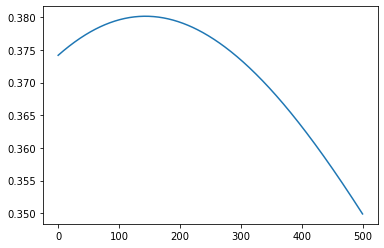

In [57]:
corr = []
for i in J_hist:
#     corr.append(loss(i, bold_bin))
    c = np.corrcoef(np.triu(fc).flatten(), np.triu(i).flatten())[0, 1]
    corr.append(c)
plt.plot(corr)

In [35]:
J = np.random.uniform(0, 1, size=(n_rois, n_rois))
J = (J + J.T)/2 # making it symmetric
np.fill_diagonal(J, 1)
gradient(J, bold_bin)

(116, 116)


array([[ 0.63941434,  0.91259763, -1.38667675, ...,  0.97732562,
        -1.271148  ,  0.80478887],
       [ 0.64981318,  0.88304238, -1.42149644, ...,  0.96666799,
        -1.29400744,  0.7888905 ],
       [-1.31800438, -1.07956325,  0.5649875 , ..., -1.07396037,
         0.73111962, -1.24096553],
       ...,
       [ 0.67193944,  0.92389227, -1.4235992 , ...,  0.91572338,
        -1.25441529,  0.77278526],
       [-1.31786791, -1.09330758,  0.5459214 , ..., -1.0628717 ,
         0.69546654, -1.24872447],
       [ 0.65624307,  0.9102043 , -1.43025217, ...,  0.93631531,
        -1.26470871,  0.73094612]])